In [1]:
import pandas as pd
import pandahouse as ph
import seaborn as sns
import numpy as np

from scipy import stats
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20220720',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }


sns.set(rc={'figure.figsize':(12,10)},
       style = 'whitegrid',
       font_scale = 1.3)

In [7]:
# сгружаем наши данные за нужный период:

q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-06-13' and '2022-06-19'
    --and exp_group in (2,1)
GROUP BY exp_group, user_id
"""

In [8]:
df = ph.read_clickhouse(q, connection=connection)

In [9]:
df

,exp_group,user_id,likes,views,ctr
0,3,115383,9,30,0.300000
1,1,18392,7,32,0.218750
2,3,123580,13,48,0.270833
3,2,131473,14,134,0.104478
4,4,107323,5,31,0.161290
...,...,...,...,...,...
50144,0,27030,8,39,0.205128
50145,3,122758,30,198,0.151515
50146,1,132567,45,296,0.152027
50147,3,122190,19,65,0.292308


In [10]:
# Считаем общий CTR в контрольных группах 0 и 1:

control_ctr1 = df[df['exp_group'] == 1].likes.sum() / df[df['exp_group']== 1].views.sum()
control_ctr0 = df[df['exp_group'] == 0].likes.sum() / df[df['exp_group']== 0].views.sum()

In [11]:
# Посчитаем поюзерные метрики  𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠=𝑙𝑖𝑘𝑒𝑠−𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙∗𝑣𝑖𝑒𝑤𝑠

df['lin_likes_1'] = df.likes - control_ctr1* df.views
df['lin_likes_0'] = df.likes - control_ctr0* df.views

<AxesSubplot:xlabel='ctr', ylabel='Count'>

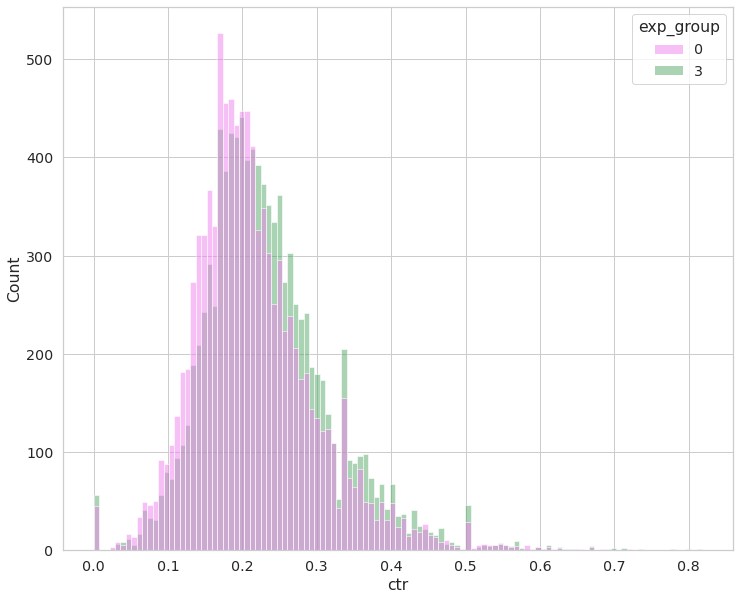

In [12]:
# строим распределения ctr для групп 0 и 3:

sns.histplot(data = df[df.exp_group.isin([0,3])],
            x = 'ctr',
            hue = 'exp_group',
            palette = ['violet','g'],
            kde = False,
            alpha = 0.5)

In [13]:
# проводим t-тест для групп 0 и 3:

stats.ttest_ind(df[df.exp_group == 0].ctr,
                df[df.exp_group == 3].ctr,
                equal_var=False)

Ttest_indResult(statistic=-13.896870721904069, pvalue=1.055849414662529e-43)

<AxesSubplot:xlabel='lin_likes_0', ylabel='Count'>

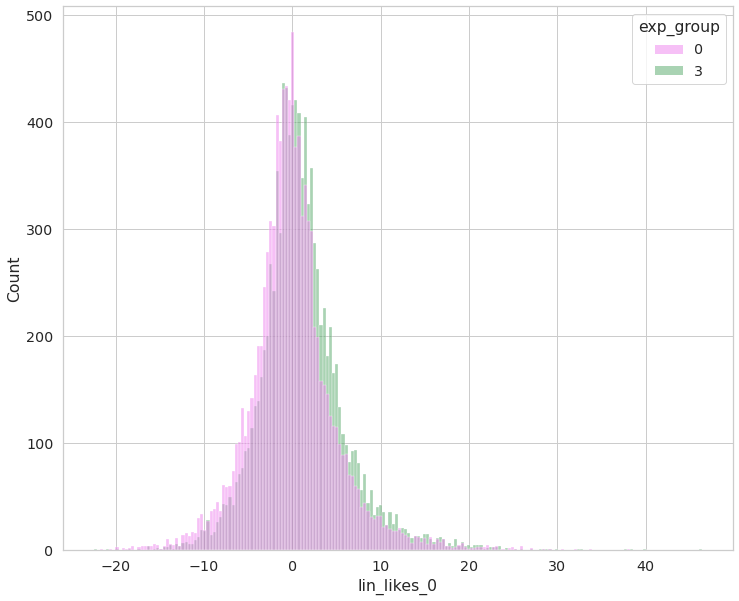

In [15]:
# строим распределения метрики linearized_likes для групп 0 и 3:

sns.histplot(data = df[df.exp_group.isin([0,3])],
            x = 'lin_likes_0',
            hue = 'exp_group',
            palette = ['violet','g'],
            kde = False,
            alpha = 0.5)

In [14]:
# проводим t-тест для групп 0 и 3 после линеаризации:

stats.ttest_ind(df[df.exp_group == 0].lin_likes_0,
                df[df.exp_group == 3].lin_likes_0,
                equal_var=False)

Ttest_indResult(statistic=-15.214995460903827, pvalue=5.4914249479690016e-52)

<AxesSubplot:xlabel='ctr', ylabel='Count'>

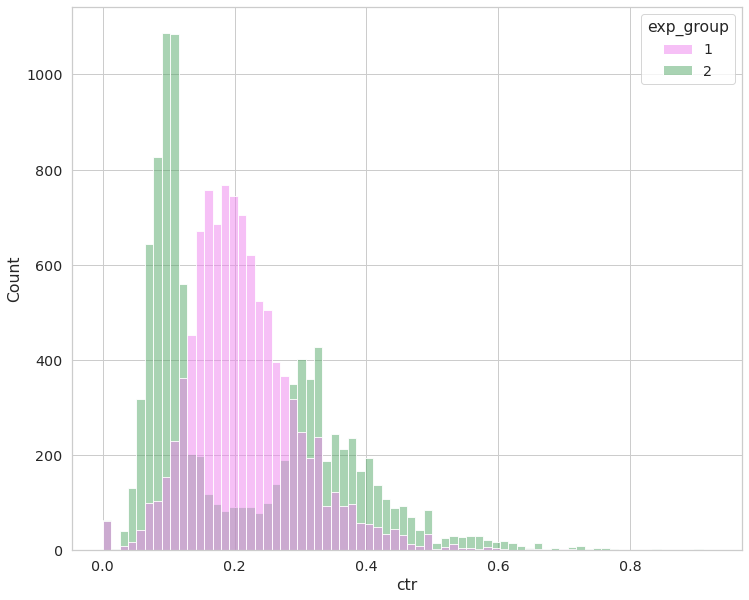

In [16]:
# строим распределения ctr для групп 1 и 2:

sns.histplot(data = df[df.exp_group.isin([1,2])],
            x = 'ctr',
            hue = 'exp_group',
            palette = ['violet','g'],
            kde = False,
            alpha = 0.5)

In [17]:
# проводим t-тест для групп 1 и 2:

stats.ttest_ind(df[df.exp_group == 2].ctr,
                df[df.exp_group == 1].ctr,
                equal_var=False)

Ttest_indResult(statistic=-0.7094392041270485, pvalue=0.4780623130874935)

<AxesSubplot:xlabel='lin_likes_1', ylabel='Count'>

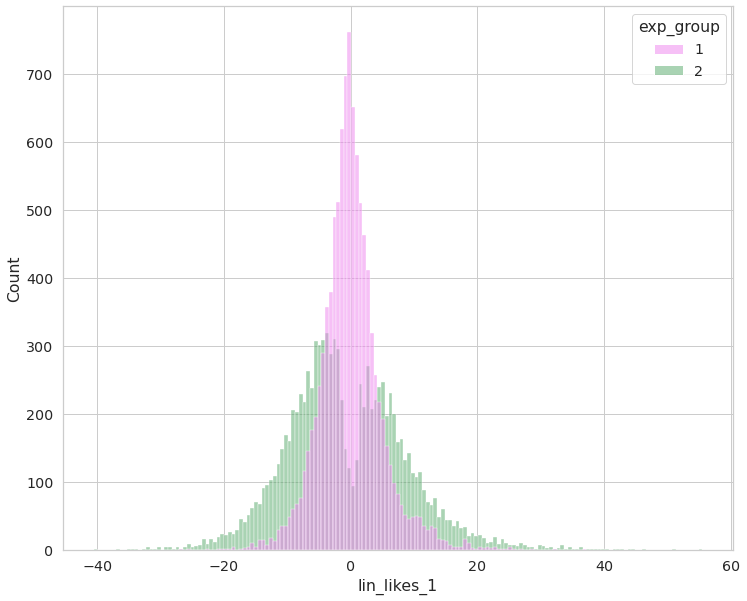

In [18]:
# строим распределения метрики linearized_likes для групп 1 и 2:

sns.histplot(data = df[df.exp_group.isin([1,2])],
            x = 'lin_likes_1',
            hue = 'exp_group',
            palette = ['violet','g'],
            kde = False,
            alpha = 0.5)

In [19]:
# проводим t-тест для групп 1 и 2 после линеаризации:

stats.ttest_ind(df[df.exp_group == 1].lin_likes_1,
                df[df.exp_group == 2].lin_likes_1,
                equal_var=False)

Ttest_indResult(statistic=6.122579994775974, pvalue=9.439432187037644e-10)

Видим, что в обоих случаях чувствительность t-теста сильно повысилась, для групп 0 и 3 p_value в обоих случаях < 0.05, вероятность получить такие или более сильные различия в ctr при условии, что H0 верна, <5%, а значит, у нас есть основания отклонить H0 о равенстве средних - имеем статистически значимый результат, группы различны.

В случае с группами 1 и 2 обычный t-тест не давал оснований отклонить нулевую гипотезу о равенстве средних, а при линеаризации pvalue< 0.05, и мы можем говорить о различии в группах.